# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

n_train = len(X_train)

n_test = len(X_test)

image_shape = X_train[0].shape

n_classes = len(set(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

0


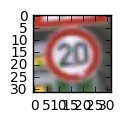

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import scipy.ndimage as ndimage



# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train))
index = 10
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
import numpy as np
from scipy.ndimage import rotate
import random


cmyk_scale = 100

def rgb_to_cmyk(R, G, B):
    
    Y =  0.299 * R + 0.587 * G + 0.114 * B
    U = -0.147 * R - 0.289 * G + 0.436 * B
    V =  0.615* R - 0.515 * G - 0.100 * B

    return Y, U, V, 0

def preprocess(trainData):
    A = trainData.shape[0]
    B = trainData.shape[1]
    C = trainData.shape[2]
    
    zeros = np.zeros((A, B, C, 1))
    resized = np.concatenate((trainData, zeros), axis=3)
        
    resized = np.subtract(resized, 128)
    resized = np.divide(resized, 128)
    
    return resized



def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # width and height of the zoomed image
    zh = int(np.round(zoom_factor * h))
    zw = int(np.round(zoom_factor * w))

    # for multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # zooming out
    if zoom_factor < 1:
        # bounding box of the clip region within the output array
        top = (h - zh) // 2
        left = (w - zw) // 2
        # zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = ndimage.zoom(img, zoom_tuple, **kwargs)

    # zooming in
    elif zoom_factor > 1:
        # bounding box of the clip region within the input array
        top = (zh - h) // 2
        left = (zw - w) // 2
        out = ndimage.zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # if zoom_factor == 1, just return the input array
    else:
        out = img
    return out

def generate_new_data(X, Y):
    print("Generating new data")
    A = X.shape[0]
    B = X.shape[1]
    C = X.shape[2]
    D = X.shape[3]
    factor = 4
    newX = np.zeros((A*factor, B, C, D))
    newY = np.zeros(A*factor)
    for idx in range(A):
        if idx % 1000 == 0:
            print("%s images processed" % idx)
        newX[idx*factor+0] = X[idx]
        newY[idx*factor+0] = Y[idx]
        
        for x in range(factor - 1):
            img = X[idx]
            img = ndimage.rotate(img, random.randint(-15, 15), reshape=False)
            img = ndimage.shift(img, (random.randint(-2, 2),random.randint(0, 2),0))
            img = clipped_zoom(img, random.randint(9, 11) * 1.0 / 10.0)
            newX[idx*factor+x+1] = img
            newY[idx*factor+x+1] = Y[idx]
        

    return newX, newY

X_train, y_train = generate_new_data(X_train, y_train)

X_train = preprocess(X_train)
X_test = preprocess(X_test)



from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)


from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)




### Preprocess the data here.
### Feel free to use as many code cells as needed.


import tensorflow as tf

EPOCHS = 30
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten
keep_prob = tf.placeholder(tf.float32)

def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
        
    # Layer 1: Convolutional. Input = 32x32x4. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 4, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Dropout
    #conv1 = tf.nn.dropout(conv1, keep_prob)


    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    

    # Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    #Dropout
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Drop out
    #fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 4))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.6})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
    saver.save(sess, 'lenet')
    print("Model saved")

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Generating new data
0 images processed


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


1000 images processed
2000 images processed
3000 images processed
4000 images processed
5000 images processed
6000 images processed
7000 images processed
8000 images processed
9000 images processed
10000 images processed
11000 images processed
12000 images processed
13000 images processed
14000 images processed
15000 images processed
16000 images processed
17000 images processed
18000 images processed
19000 images processed
20000 images processed
21000 images processed
22000 images processed
23000 images processed
24000 images processed
25000 images processed
26000 images processed
27000 images processed
28000 images processed
29000 images processed
30000 images processed
31000 images processed
32000 images processed
33000 images processed
34000 images processed
35000 images processed
36000 images processed
37000 images processed
38000 images processed
39000 images processed
Training...

EPOCH 1 ...
Validation Accuracy = 0.846
EPOCH 2 ...
Validation Accuracy = 0.912
EPOCH 3 ...
Validat

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [5]:
# I first generated some additional data by adding 4 transformed versions of the original training set. The
# transformation consists of a combination of position translation ([-2,2] pixels), in scale ([.9,1.1] ratio)
# and rotation ([-15,+15] degrees). By adding these addtional perturbed data, we can prevent the model from
# overfitting and the model will be more robust to slight changes in the traffic sign's representation.

# I then shuffle the data set because I don't want the model to learn from the order of the data set.

# I also made the data set roughly zero mean and in the range of [-1, 1] by subtracting 128 from the numbers 
# and dividing them by 128. I found this improved the validation accuracy quite a lot.

# I finally split the original training set into training set and validation set in the ratio of 4:1.



### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [6]:
# My training and validation sets are splitted subsets of the original training set and my testing data
# is the original testing data. I added additional data set by adding transformed versions of the original data.
# I have described the detail of that process in my answer to Question 1.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [7]:
# My model is based on the canonical LeNet model that we used in the codelab. I added dropout regulation layers
# to help the model from overfitting. I've experimented multiple dropout setups: on different layers, and different
# keep probabilities. The best setup I found is one dropout layer after the last layer of convolutional layer and
# another dropout layer after the second to the last fully connected layer. The keep probability that I chose for
# both dropout layers is 0.6.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

In [8]:
# I used AdamOptimizer, batch size 128, 30 epochs, learning rate 0.001. I found these configurations will yield
# the highest validation accuracy. 

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

In [9]:
# I tried adding drop out layers after every layer, but I found the result was not as good as just two drop out
# layers. It looks like four drop out layers are just too much regulation. I also tried keep probability between
# 0 and 1 and found that range 0.6-0.8 is usually a good choice.

# I also tried to preprocess the images by converting their color spaces. The heuristic behind this was that most
# traffic signs have red, yellow, blue instead red green blue. Converting it to another color space may potentially
# make the features more representing of the meaning behind it. I tried CMYK space and YUV space, but for both I
# got similar result without the conversion.

# I also tried to feed the lower level features forward to the last layer of the neural network. The heuristic is
# to make predictions not just based on higher level features, but also lower level features. However, this
# increases network complexity and I even got a drop in validation accuracy for this modification so I did not
# include this change in my final architecture.

# I also wanted to apply color correction and some other image processing techniques to enhance the quality of the
# images. However, I didn't the time to do that. I would imagine that it will increase the accuracy.


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

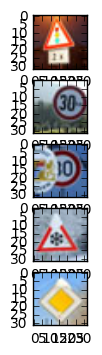

In [10]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import scipy.ndimage as ndimage
import matplotlib.pyplot as plt


img1 = ndimage.imread('new1.jpg')
img2 = ndimage.imread('new2.jpg')
img3 = ndimage.imread('new3.jpg')
img4 = ndimage.imread('new4.jpg')
img5 = ndimage.imread('new5.jpg')
X = np.asarray([img1, img2, img3, img4, img5])
zeros = np.zeros((5, 32, 32, 1))
X = np.concatenate((X, zeros), axis=3)

%matplotlib inline
plt.figure()
plt.subplot(511)
plt.imshow(img1, cmap="gray")

plt.subplot(512)
plt.imshow(img2, cmap="gray")

plt.subplot(513)
plt.imshow(img3, cmap="gray")

plt.subplot(514)
plt.imshow(img4, cmap="gray")

plt.subplot(515)
plt.imshow(img5, cmap="gray")
  
    

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [11]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    result = sess.run(logits, feed_dict={x: X, keep_prob: 1})
    a = sess.run(tf.nn.top_k(tf.constant(result), k=5))
    # print the top 5 class ids with the highest probabilities
    print(a.values)
    print(a.indices)
    # The correct labels are
    # 26,traffic signals
    # 1,Speed limit (30km/h)
    # 1,Speed limit (30km/h)
    # 30,Beware of ice/snow
    # 12,Priority road


[[  1.88096420e+02   5.89188881e+01  -3.91066513e+01  -2.80635254e+02
   -2.82452362e+02]
 [  1.17338181e+02   9.22298126e+01   1.41538744e+01   2.84300661e+00
   -1.33226109e+00]
 [  1.15726587e+03   7.17264404e+02   5.62411804e+02  -1.32717886e+01
   -4.94528275e+01]
 [  6.40706238e+02   6.22928528e+02   5.80247253e+02   5.29965454e+02
   -5.00105190e+00]
 [  3.51010718e+03  -5.94691345e+02  -1.11571545e+03  -1.38121338e+03
   -1.50732996e+03]]
[[ 9 20 22 28 25]
 [ 2 28  9 11  1]
 [ 1  2  3  5 21]
 [28 29 30 23 11]
 [12 13 17 25 11]]


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [12]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

# My model predicted 3 out of 5 signs correctly. 60% accuracy. This does not mean that the model will not generalize
# well because 1. test size of 5 is pretty small. 2. these are not easy ones to classify.

# The third sign is obstructed partially. And it's really hard even for human eyes to tell if it's 30km/h
# speed limit or 80km/h speed limit. And as I would expect, both 30km/h and 80km/h appear in the top 5 probabilities 
# (80km/h ranked 4th).

# The worst performance is for the first sign. The correct label does not appear in the top 5. From the probability
# values we can see that the top 5 have similar probabilites, which means that the model is not certain about its
# prediction. The picture was taken from an angle. I think that might be the reason why it performed so poorly. We
# could get more such pictures and add them into the training set to improve performance.

# The fourth sign was classified wrong but the probability of the correct label comes second highest. This picture
# was partially obstructed. Adding more such partially obstructed pictures could also improve performance.

# The fifth sign was classified correctly, and from the probabilities we can see that there's a clear winner. The
# top probability is significant higher than the second one.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

In [13]:
# Please see my answers for Question 7. I have included my detailed analysis there.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

# 